# Image Reconstruction using CNN

Here, I will investigate if we can use DL to reconstruct MNIST data that has been encoded with coded aperture.   
**Research Question:** Given a coded image, 
(1) can we recover/reconstruct the image, and
(2) can we recover the decoding pattern?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn.utils as utils
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import reconstruction_cnn
import confusion_matrix as cm
import wandb_functions as wf

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,7],#[15,10],
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Prepare MNIST Data

## Hyperparameters
Here, I will define hyperparameters for both the model and some needed for preprocessing.  

To define the MURA encoding and decoding, we first define a size $p$ for the MURA array and then use the encoder and decoding functions to create the encoder array $A$ and the decoder array $G$

In [5]:
%%time
# define hyperparameters
params = {
  "dataset": "encoded_MNIST",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 30,
  "kernel_size":23,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kind": "recon",
  "suffix": "activation_mae", # "l_1_pen_lambda_", #"activation",#
  "lambda": 0,
  "loss": "MAE",
  "optimizer": "Adam"
}
params['model'] = params['kind']+'_' + params['suffix'] 
if params['lambda'] != 0:
    params['model'] = params['model'] + f"{params['lambda']:.0e}" 
#params['model_save_path'] = f'../models/{params["kind"]}/{params["model"]}.pth'

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
wandb.config = wf.wandb_config(params)

CPU times: user 1.51 ms, sys: 75 µs, total: 1.58 ms
Wall time: 1.57 ms


# Load data and define model

In [6]:
%%time
mura_train_data, mura_eval_data, mura_test_data, loaders = reconstruction_cnn.load_data(params)

# Instantiate model 
model = reconstruction_cnn(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) #torch.optim.SGD(model.parameters(), lr = model.params['learning_rate'])

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000
Using the following parameters:
dataset: encoded_MNIST
learning_rate: 0.001
batch_size: 100
epochs: 30
kernel_size: 23
p: 23
image_size: 23
kind: recon
suffix: activation_mae
lambda: 0
loss: MAE
optimizer: Adam
model: recon_activation_mae
A: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0.

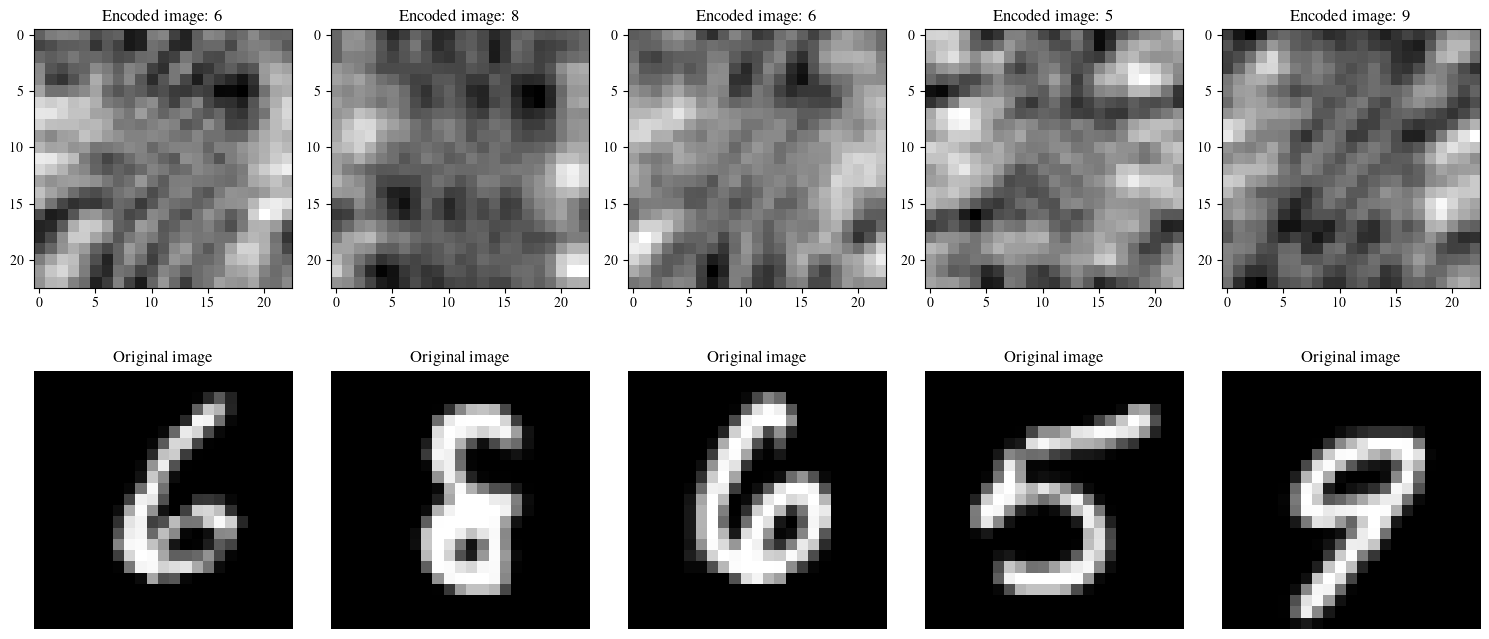

In [7]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(mura_train_data[idx][0][0].numpy(), cmap='gray')
    #plt.colorbar()
    plt.title(f'Encoded image: {mura_train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    plt.imshow(mura_train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

# Training

## Look at initial weights

Initial weights Shape: torch.Size([1, 1, 23, 23])


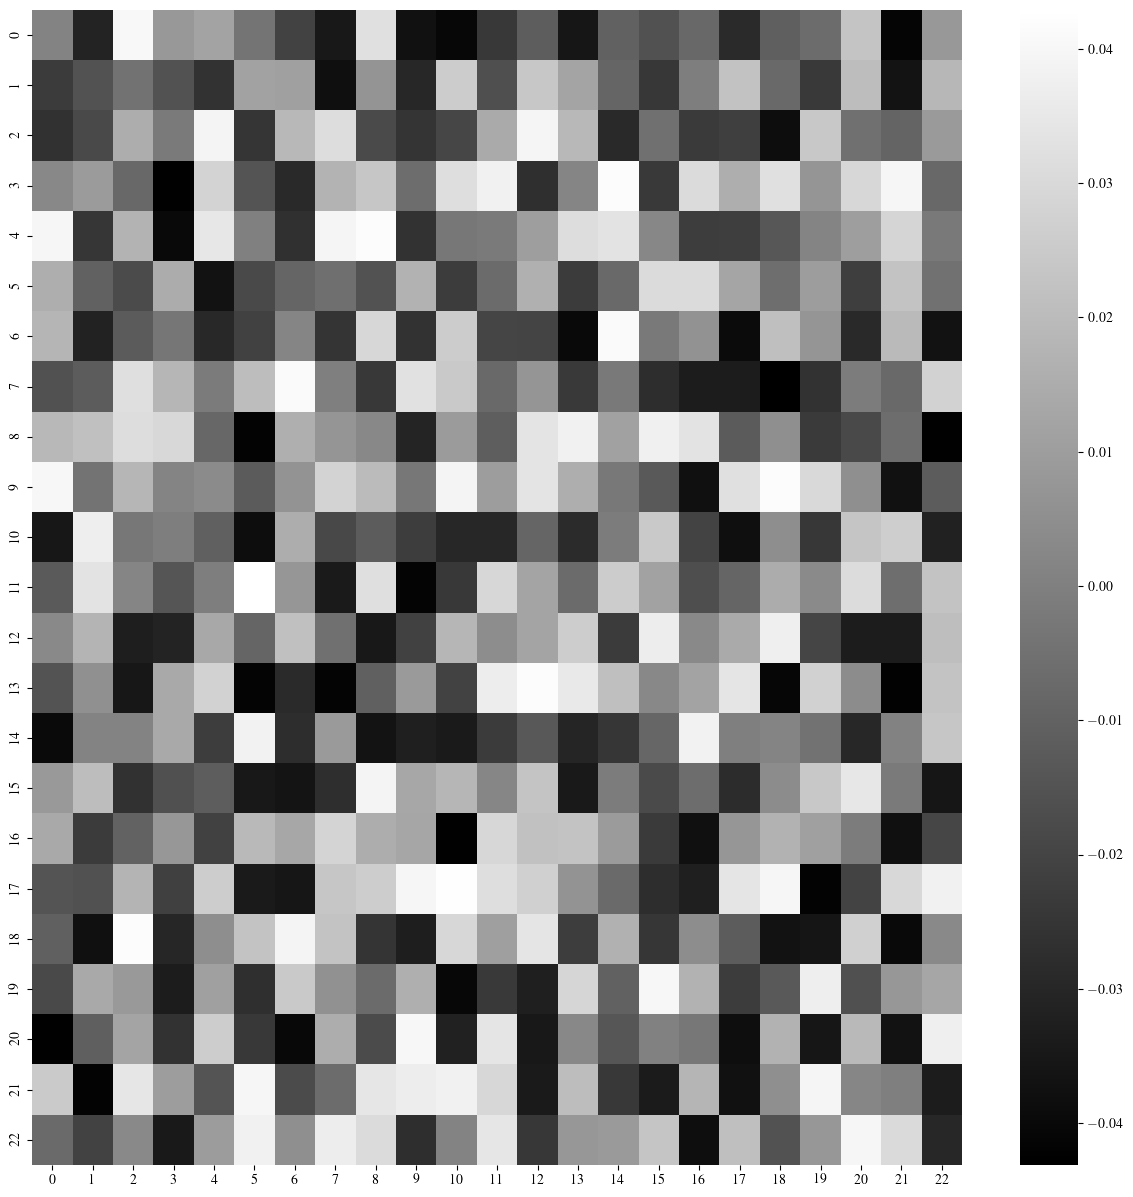

Target weights shape: (23, 23)


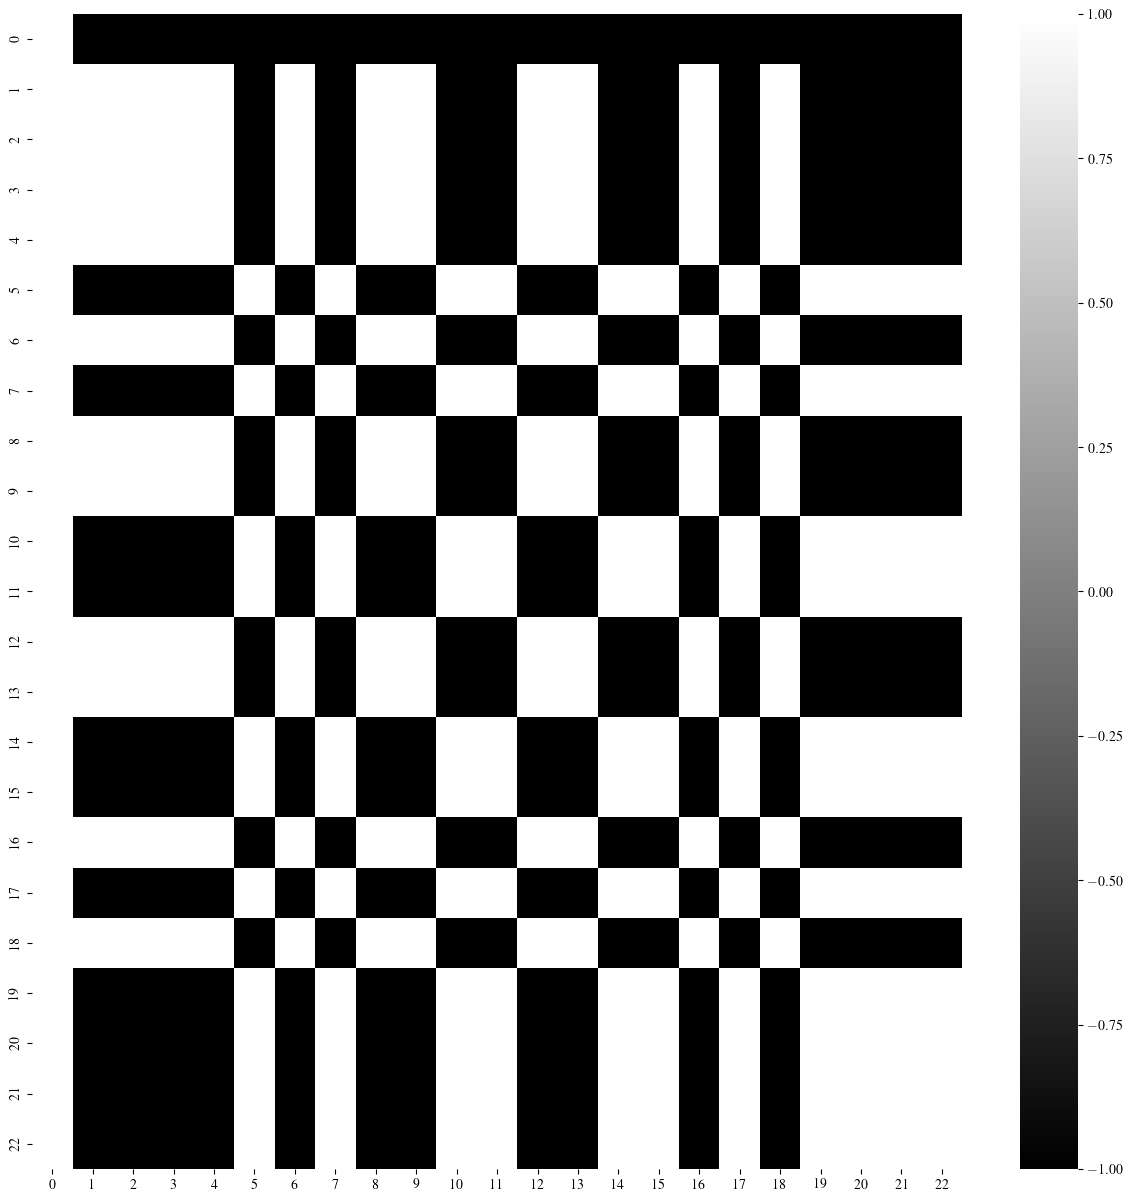

In [10]:
# ----------- Plot initial weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weights[0].shape))

# Plot initial weights
plt.figure(figsize=(15,15))
heat = sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_init.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

# Define and plot target weights
target_weights = model.params['G']
print('Target weights shape: {}'.format(target_weights.shape))
plt.figure(figsize=(15,15))
heat = sns.heatmap(target_weights, cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_target.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

## Train

In [8]:
%%time
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="coded-aperture-MNIST", 
           group=model.params["kind"], 
           name=f"{model.params['model']}_exp1/p2")

# Store values for later 
train_loss = []
val_loss = []
frob_per_epoch = []

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    model.train()
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [images, labels, digit]
        inputs, targets, digits = data
        
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = model.criterion(out, targets)
        # Modified (04/06/23) to include l_1 penalty
        l_1_pen = sum((w.abs()-1).abs().sum() for w in model.parameters())
        loss = loss + (model.params['lambda']/(model.params['p']**2)) * l_1_pen
        
        # zero the parameter gradients
        model.optimizer.zero_grad()
        # Backprop and update weights
        loss.backward()
        model.optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
    
    # Average loss over entire dataset
    running_loss/= len(loaders['train'].dataset)#params['batch_size']
    train_loss.append(running_loss)  
    
    
    # --------------------- Validation ------------------
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(loaders['eval']):
            vinputs, vtargets, vdigits = vdata
            voutputs = model(vinputs)
            # validation loss modified to include penalty
            vloss = (model.criterion(voutputs, vtargets) + (model.params['lambda']/(model.params['p']**2)) * l_1_pen).item()
            #vloss = model.criterion(voutputs, vtargets)
            running_vloss += vloss
        running_vloss/= len(loaders['eval'].dataset)
        val_loss.append(running_vloss) 

    
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f} | Val_loss: {running_vloss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, "val_loss": running_vloss})
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
    # Save weights every 10 epochs
    if epoch % 10 == 9:
        if abs(train_loss[epoch] < train_loss[epoch-1]):
            torch.save(model.state_dict(), model.params['model_save_path'])
        # epoch_save_model = path+f'models/CNN/{params["model"]}_model_epoch_'+str(epoch)+'.pth'
        # torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weight_epoch = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        plt.figure(figsize=(15,15))
        heat = sns.heatmap(weight_epoch, cmap='gray')
        figure = heat.get_figure()
        figure.savefig(path+f'/metrics/CNN/{params["model"]}_model_heat_epoch_'+str(epoch)+'.png',dpi=400)
        plt.close()
    
    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = params['G'] - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))

#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 0.0014210 | Val_loss: 0.0012659
Epoch 2 | Loss: 0.0013144 | Val_loss: 0.0012599
Epoch 3 | Loss: 0.0013113 | Val_loss: 0.0012583
Epoch 4 | Loss: 0.0013102 | Val_loss: 0.0012576
Epoch 5 | Loss: 0.0013097 | Val_loss: 0.0012573
Epoch 6 | Loss: 0.0013094 | Val_loss: 0.0012570
Epoch 7 | Loss: 0.0013093 | Val_loss: 0.0012569
Epoch 8 | Loss: 0.0013092 | Val_loss: 0.0012568
Epoch 9 | Loss: 0.0013091 | Val_loss: 0.0012567
Epoch 10 | Loss: 0.0013090 | Val_loss: 0.0012567
Epoch 11 | Loss: 0.0013090 | Val_loss: 0.0012567
Epoch 12 | Loss: 0.0013090 | Val_loss: 0.0012566
Epoch 13 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 14 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 15 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 16 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 17 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 18 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 19 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 20 | Loss: 0.0013089 | Val_loss: 0.0012566
Epoch 21 | Loss: 0.0013089 | 

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
loss,0.00131
val_loss,0.00126


CPU times: user 17min 23s, sys: 9.41 s, total: 17min 33s
Wall time: 17min 58s


In [9]:
PATH = model.params['model_save_path']
torch.save(model.state_dict(), PATH)

In [10]:
#----------------------------- Save The Losses -----------------------------
import pickle
with open(path+f'metrics/CNN/train_loss_{params["model"]}.pkl','wb') as fp:
    pickle.dump(train_loss, fp)
with open(path+f'metrics/CNN/validation_train_loss_{params["model"]}.pkl','wb') as fp:
    pickle.dump(val_loss, fp)
with open(path+f'metrics/CNN/weight_norm_{params["model"]}.pkl','wb') as fp:
    pickle.dump(frob_per_epoch, fp)
with open(path+f'metrics/CNN/outputs_per_epoch_{params["model"]}.pkl','wb') as fp:
    pickle.dump(outputs, fp)

# Evaluation

In [9]:
# Load model if one is not loaded already
PATH = model.params['model_save_path']#path+f'models/CNN/{params["kind"]}_model_epoch_{params["epochs"]}.pth'
model.load_state_dict(torch.load(PATH))
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

conv.weight
conv.bias


In [13]:
# Load Frobenius norm and training loss
train_loss = np.load(path+f'metrics/CNN/train_loss_{params["model"]}.pkl', allow_pickle=True)
val_loss = np.load(path+f'metrics/CNN/validation_train_loss_{params["model"]}.pkl', allow_pickle=True)
frob_per_epoch = np.load(path+f'metrics/CNN/weight_norm_{params["model"]}.pkl', allow_pickle=True)
outputs = np.load(path+f'metrics/CNN/outputs_per_epoch_{params["model"]}.pkl', allow_pickle=True)

## Plot training loss

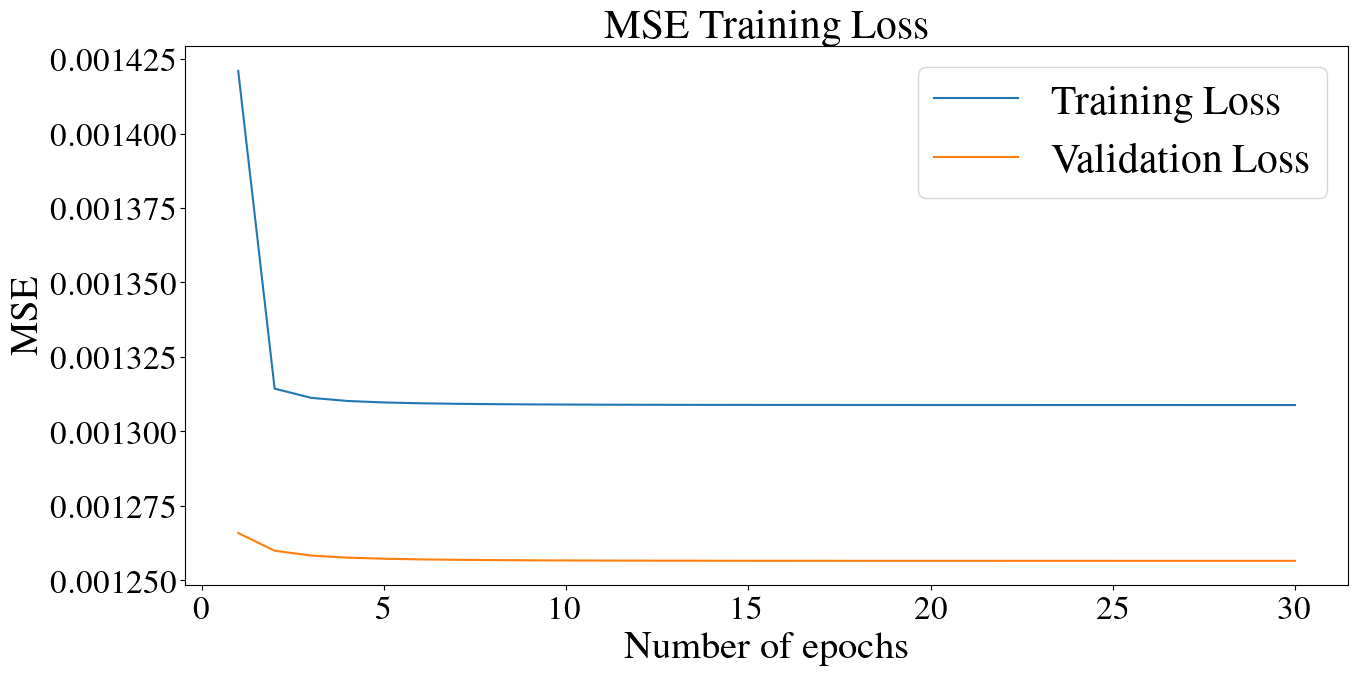

In [11]:
# Plotting the training loss
fontsize = 30

fig, axs = plt.subplots(1,1)
axs.plot(range(1,params['epochs']+1), train_loss, label="Training Loss")
axs.plot(range(1,params['epochs']+1), val_loss, label="Validation Loss")
# axs.plot(range(1,40+1), train_loss, label="Training Loss")
# axs.plot(range(1,40+1), val_loss, label="Validation Loss")

axs.set_xlabel("Number of epochs", fontsize = fontsize-2)
axs.set_ylabel("MSE", fontsize = fontsize-2)
axs.set_title("MSE Training Loss", fontsize=fontsize)
plt.xticks(fontsize=fontsize-6)
plt.yticks(fontsize=fontsize-6)
plt.legend(fontsize=fontsize-6)
axs.legend(fontsize=fontsize)
#plt.savefig(f'../figs/training_loss_{params["model"]}_{params["epochs"]}epochs.png')
plt.show()

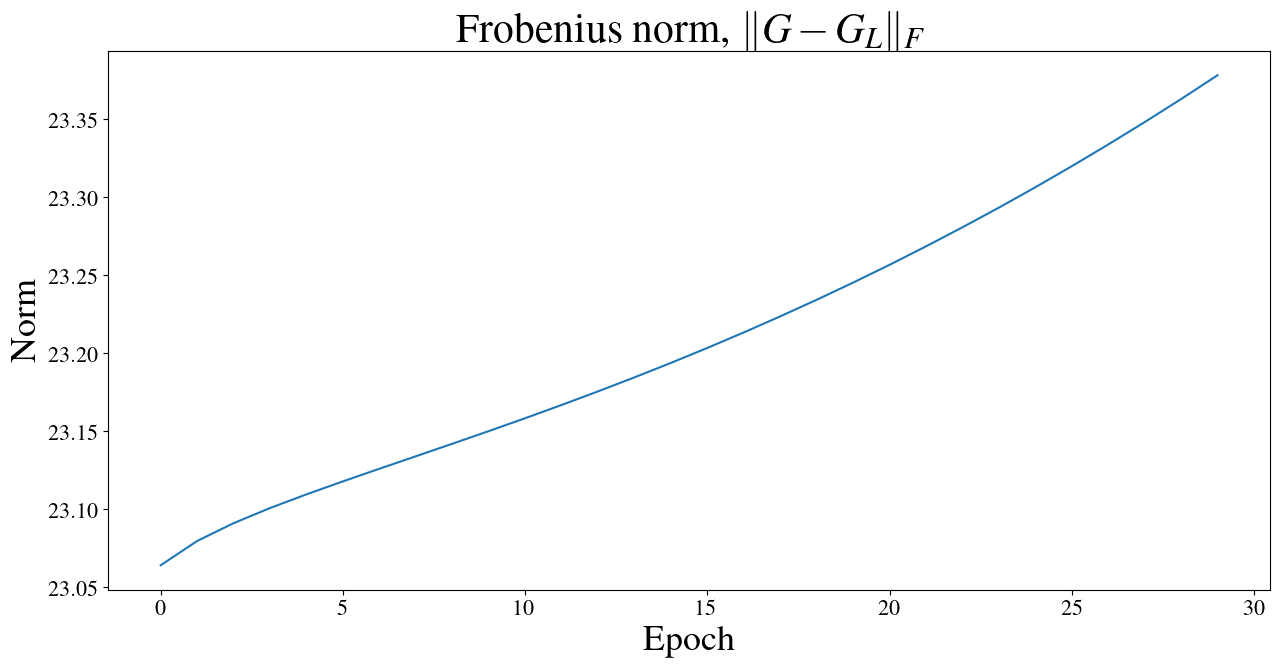

In [12]:
# # Plot weights
# plt.imshow(torch.squeeze(model.state_dict()['conv.weight']), cmap='gray')
# plt.colorbar()
# plt.show()
fontsize=30
# plot frob per epoch
plt.plot(np.arange(params['epochs']), frob_per_epoch)
# plt.plot(np.arange(40), frob_per_epoch)

plt.title("Frobenius norm, $\|G-G_L\|_F$", fontsize=fontsize)
plt.xlabel("Epoch", fontsize=fontsize-4)
plt.ylabel("Norm", fontsize=fontsize-4)
plt.xticks(fontsize=fontsize-14)
plt.yticks(fontsize=fontsize-14)
#plt.savefig(path+f'figs/frob_per_epoch_{params["model"]}.png')
plt.show()

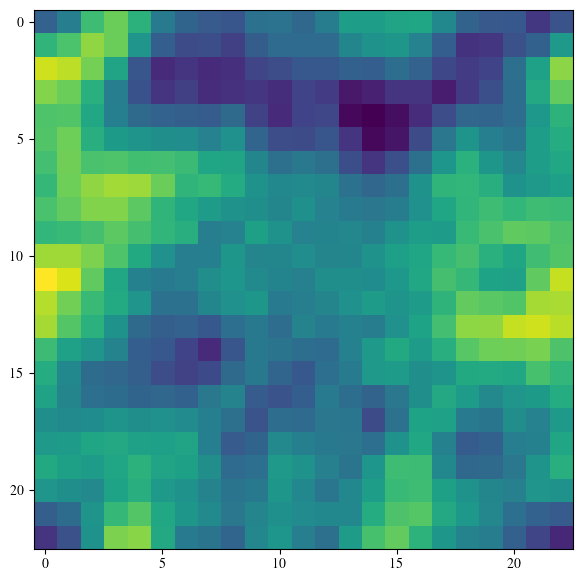

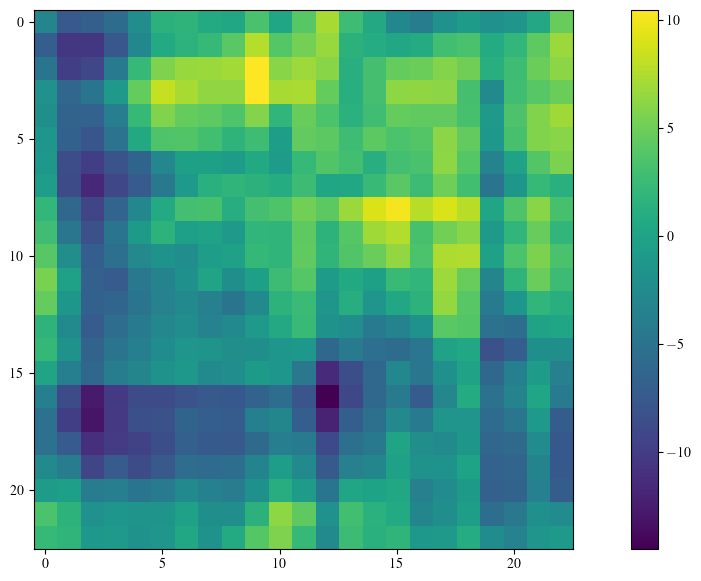

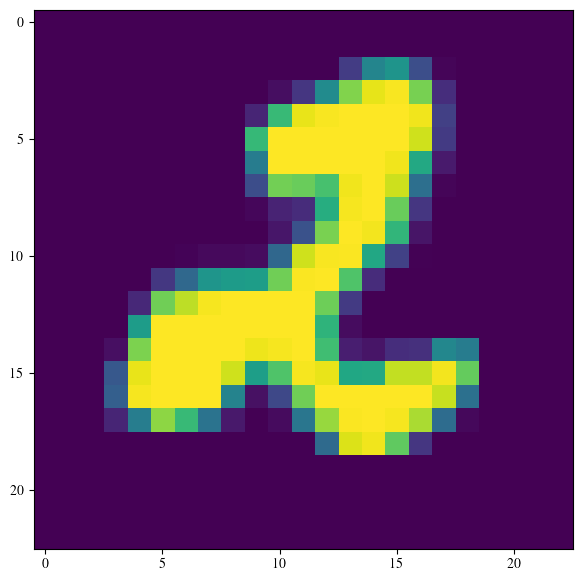

In [16]:
# Plot progression of model throughout the epochs
idx = 50
plt.imshow(torch.reshape(outputs[idx]['img'][10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['out'].detach()[10], (model.img_size, model.img_size))); plt.colorbar();plt.show()
plt.imshow(torch.reshape(outputs[idx]['targets'][10], (model.img_size, model.img_size))); plt.show()

# Look at weights

In [13]:
#------------------------- Save the final weights --------------------------
final_weights = list(model.parameters())
final_weight_map = final_weights[0].detach().cpu().numpy()
#np.save(path+'metrics/final_weight_CNN_23kernel',final_weight_map)
#print(final_weight_map.shape)

# Just visualizations of decoder if we threshold some way
# Threshold weights so negative values go to -1 and positive values go to 1
weights_theshold = final_weight_map.copy()
weights_theshold[weights_theshold >= 0] = 1
weights_theshold[weights_theshold < 0] = -1

weights_clip = final_weight_map.copy()
weights_clip = np.clip(weights_clip,-1,1)

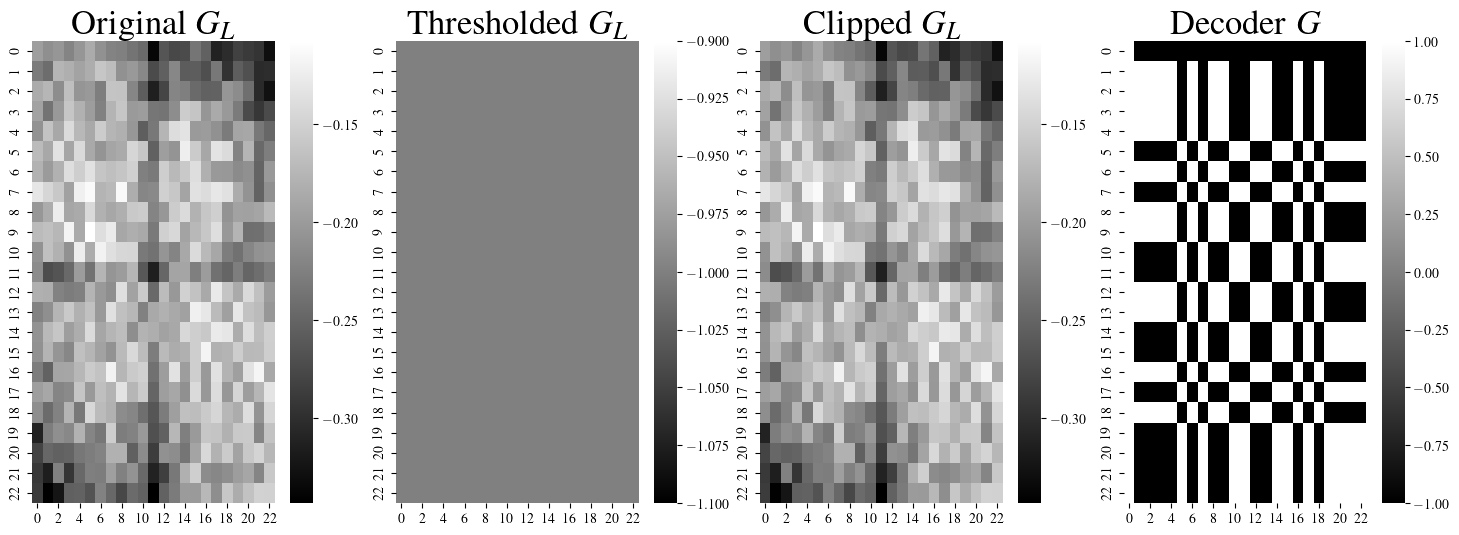

In [14]:
title_size = 25
fig, axs = plt.subplots(1,4, figsize=(18,6))
sns.heatmap(np.squeeze(final_weight_map), cmap='gray', ax = axs[0])
sns.heatmap(np.squeeze(weights_theshold), cmap='gray', ax = axs[1])
sns.heatmap(np.squeeze(weights_clip), cmap='gray', ax = axs[2])
sns.heatmap(params['G'], cmap='gray', ax = axs[3])

axs[0].set_title("Original $G_L$", fontsize = title_size)
axs[1].set_title("Thresholded $G_L$", fontsize = title_size)
axs[2].set_title("Clipped $G_L$", fontsize = title_size)
axs[3].set_title("Decoder $G$", fontsize = title_size)
plt.show()

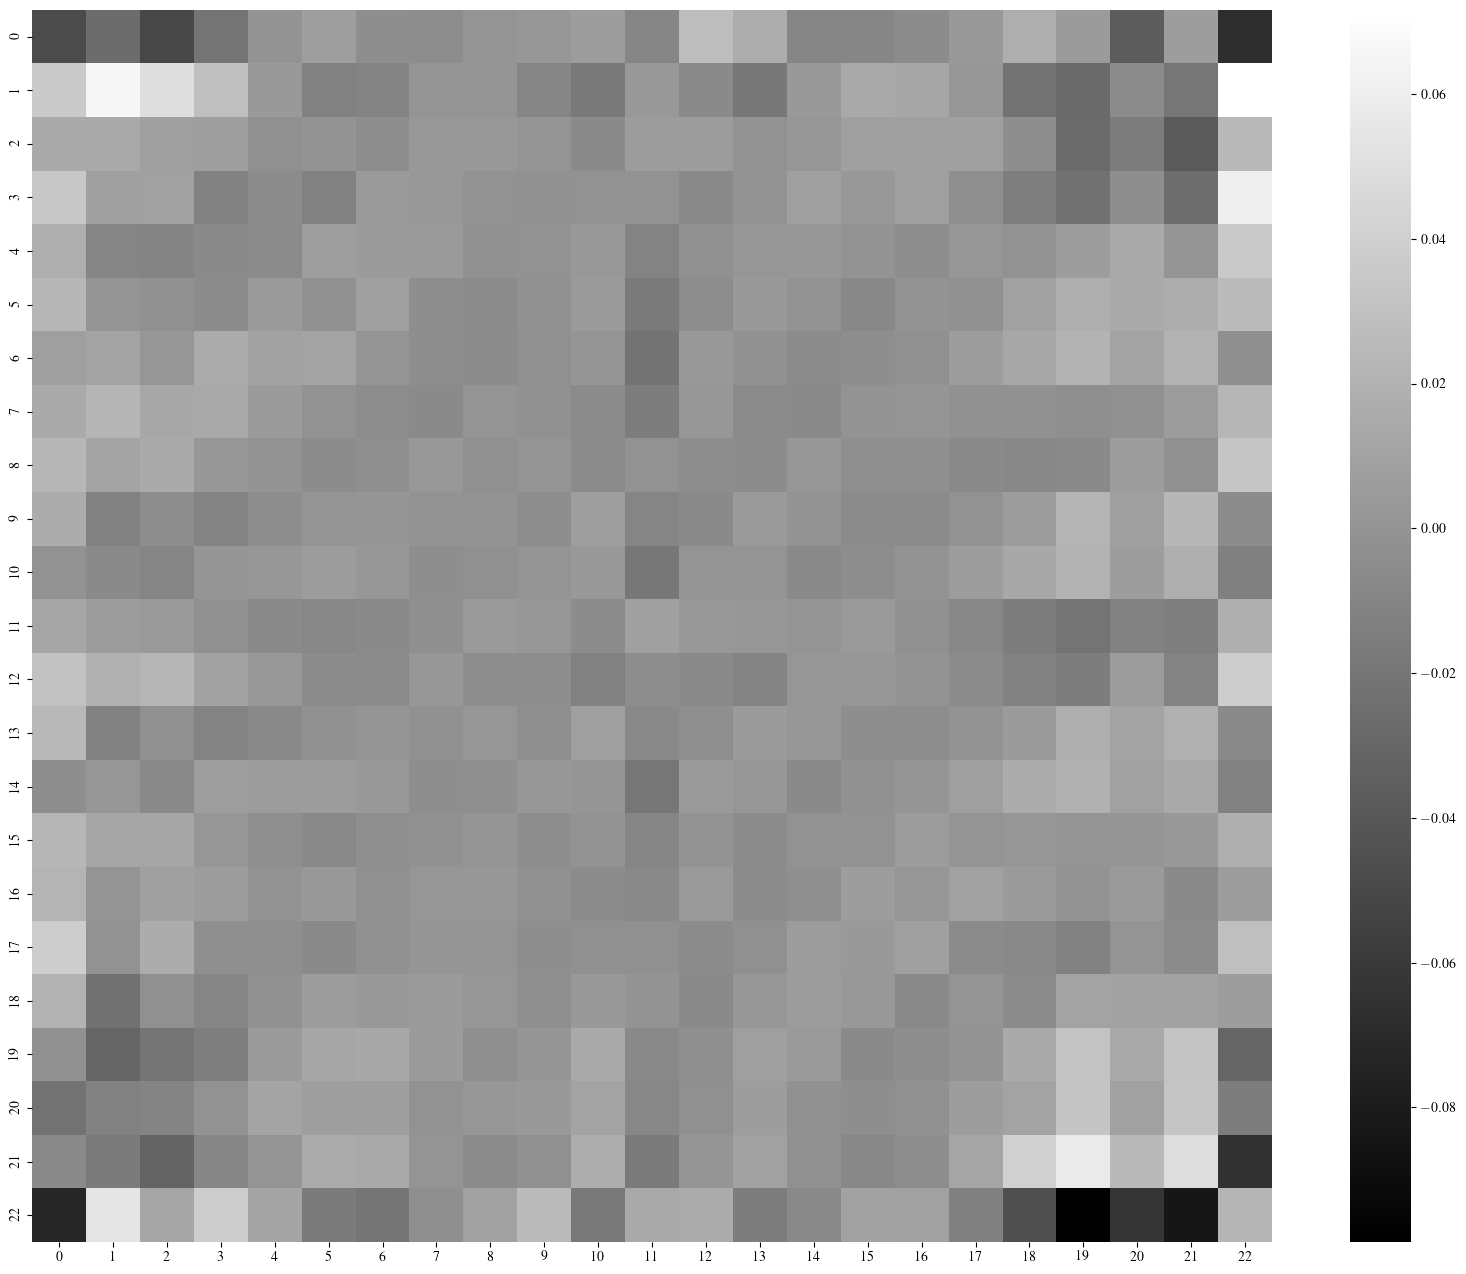

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [20,16],
})
sns.heatmap(np.squeeze(final_weight_map), cmap='gray')
plt.show()

# sns.heatmap(np.squeeze(weights_theshold), cmap='gray')
# plt.show()

# Code for validation set evaluation

In [15]:
# Initialize variables
images_all = []
predicted_all = []
labels_all = []
digit_labels_all = []
mse_all = []
mae_all = []
test_outputs = {}

with torch.no_grad():
    # for param in model.parameters():
        # Constrain weights to -1 and 1 by pushing negative values to -1 and positive values to 1
        # param[param < 0] = -1
        # param[param > 0] =  1
        
        # Clip weights so that range is [-1,1]
        # param[param < -1] = -1
        # param[param > 1] =  1

    # Evaluate validation set
    for data in loaders['eval']:
        # get images and labels from test set
        img_batch, label_batch, digit_batch = data
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction, digit in zip(img_batch, label_batch, pred_batch, digit_batch):
            one_mse = sklearn.metrics.mean_squared_error(torch.squeeze(label), torch.squeeze(prediction))
            one_mae = sklearn.metrics.mean_absolute_error(torch.squeeze(label), torch.squeeze(prediction))
            
            # Store values in lists
            mse_all.append(one_mse)
            mae_all.append(one_mae)
            images_all.append(image)
            labels_all.append(label)
            predicted_all.append(prediction)
            digit_labels_all.append(digit.numpy())
            
            
    # Storing information in dictionary
    test_outputs['img']       = images_all
    test_outputs['label']     = labels_all
    test_outputs['pred']      = predicted_all
    test_outputs['digit']     = digit_labels_all
    test_outputs['mse_score'] = mse_all
    test_outputs['mae_score'] = mae_all

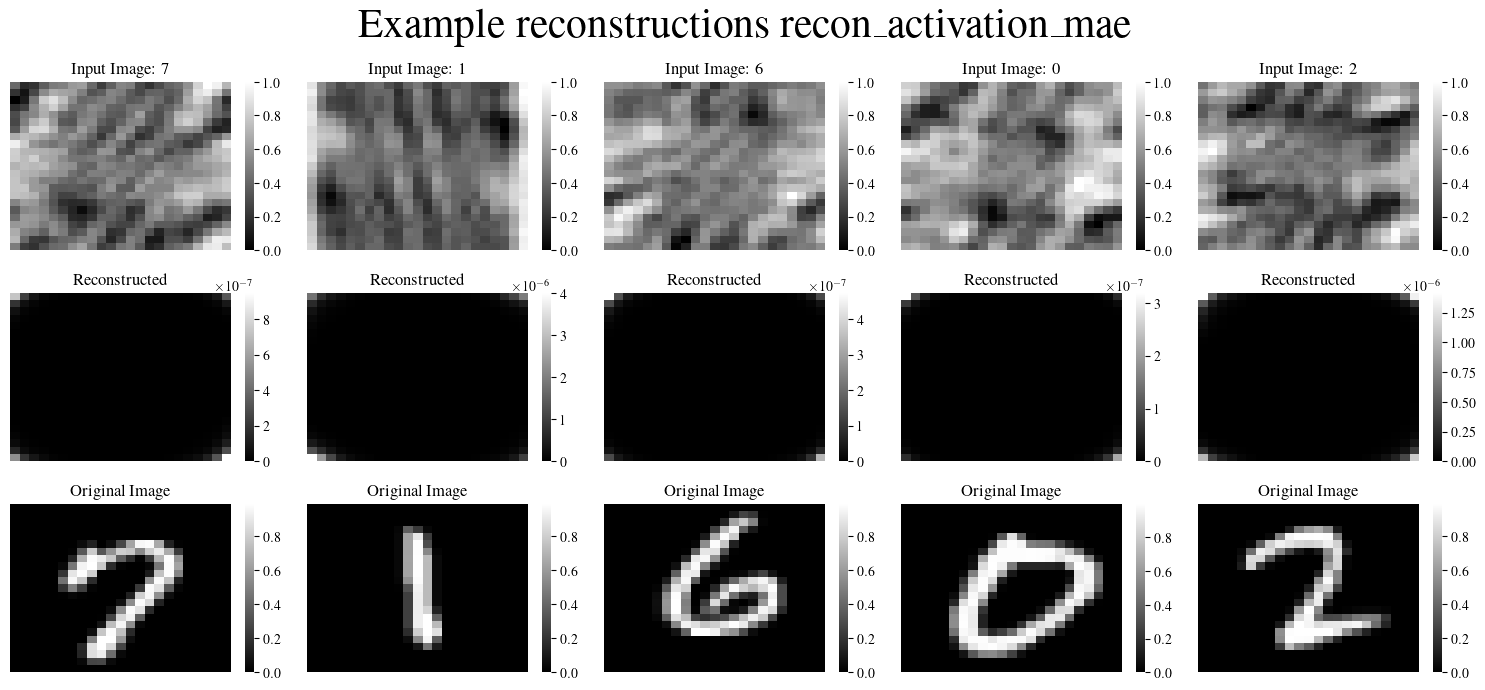

In [18]:
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
num_examples = 5
plt.rcParams.update({
    "figure.figsize" : [15,7],
})
# Plotting original images

# Plotting first num_examples images
for idx in range(num_examples):
    val = test_outputs['img']
    plt.subplot(3, num_examples, counter)
    sns.heatmap(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    #plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title(f"Input Image: {test_outputs['digit'][idx]}")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

# Plotting reconstructions
val = test_outputs['pred']#.numpy()
  
# Plotting first num_examples images of the batch
for idx in range(num_examples):
    plt.subplot(3, num_examples, counter)
    plt.title("Reconstructed")
    sns.heatmap(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    #plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')#, vmin=0, vmax=1)
    #plt.colorbar()
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting label images

# Plotting first num_examples images
for idx in range(num_examples):
    val = test_outputs['label']
    plt.subplot(3, num_examples, counter)
    sns.heatmap(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    #plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
plt.suptitle(f"Example reconstructions {params['model']}", fontsize=30)
#plt.savefig(path+f'figs/example_recons_{params["model"]}.png')
plt.tight_layout()
plt.show()

# Pandas DF with Images, Labels, Predictions, Digits, and MSE Scores

In [39]:
df = pd.DataFrame.from_dict(test_outputs)
df.digit = df.digit.astype('str')
df.head()
df.mse_score.describe()

count    7000.000000
mean        0.095679
std         0.037754
min         0.014726
25%         0.069145
50%         0.091731
75%         0.116534
max         0.318864
Name: mse_score, dtype: float64

In [40]:
df.mae_score.describe()

count    7000.000000
mean        0.127715
std         0.041278
min         0.034598
25%         0.099124
50%         0.124768
75%         0.152289
max         0.352205
Name: mae_score, dtype: float64

### Plot MSE scores for the whole test set

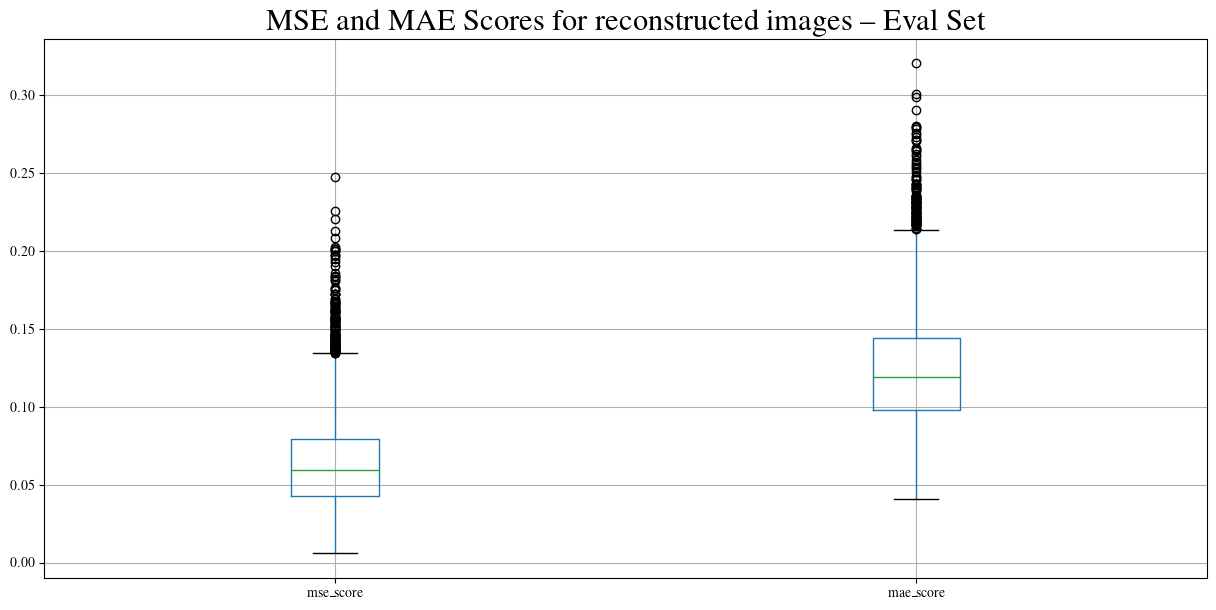

In [18]:
# Plot MSE scores for the whole test set
df.boxplot(column=['mse_score', 'mae_score'])
plt.title("MSE and MAE Scores for reconstructed images -- Eval Set", fontsize=22)
#plt.savefig('../figs/mse_test_recon.png')
plt.show()

### Plot MSE scores by digit for the whole test set

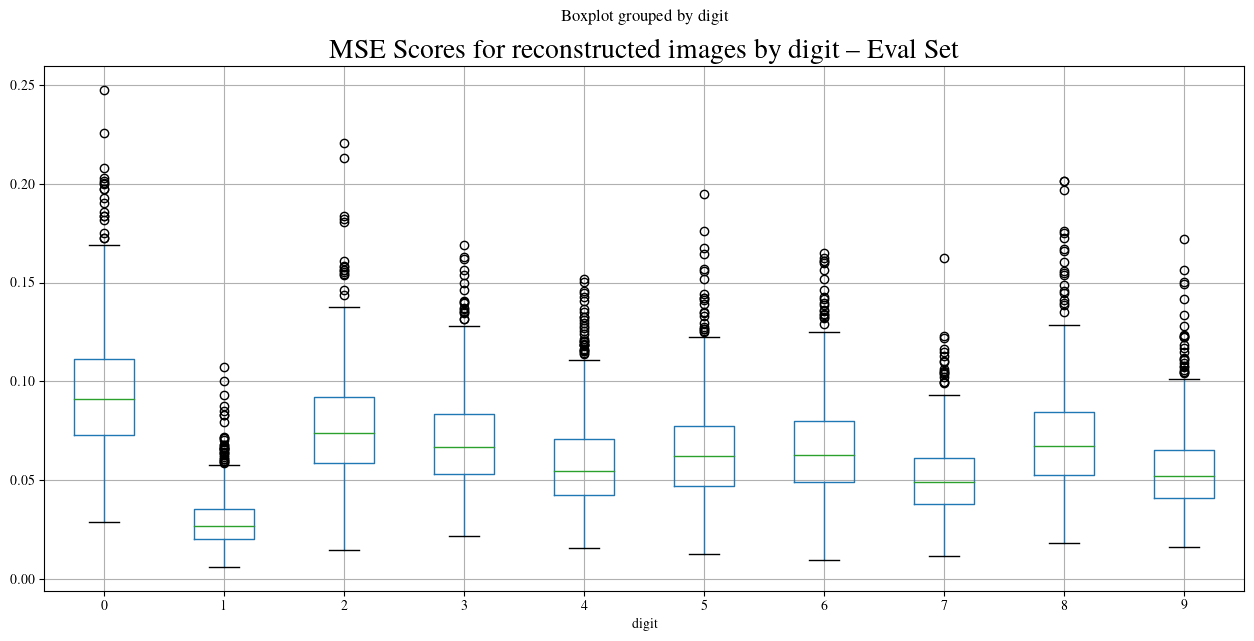

In [19]:
# Plot MSE scores by digit for the whole test set
df.boxplot(column='mse_score', by='digit')
plt.title("MSE Scores for reconstructed images by digit -- Eval Set", fontsize=20)
#plt.savefig('../figs/mse_test_recon_digits.png')
plt.show()

## Bad preds

In [49]:
# get all the entries that are above the mean MSE
# higher MSE means worse reconstructions, so we want to look at those
bad_preds = df[df.mse_score > df.mse_score.describe()[1]].copy()

In [50]:
# See which digits have MSE above the mean (i.e. which digits did the model do worse at reconstructing?)
bad_preds.digit.astype('int64').value_counts(normalize=True)

0    0.184372
5    0.140487
2    0.133797
8    0.124967
3    0.119615
4    0.080278
1    0.065828
6    0.064490
7    0.054054
9    0.032111
Name: digit, dtype: float64

## Plotting quantiles

In [31]:
# Get top 25% entries
# count    10000.000000
# mean         0.061068
# std          0.039483
# min          0.002345
# 25%          0.033087
# 50%          0.053249
# 75%          0.079502
# max          0.330395
top_25per = df[df.mse_score < df.mse_score.describe()[4]]#.sample(n=5).index
bottom_25per = df[df.mse_score > df.mse_score.describe()[6]]

In [33]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [20,16],
})

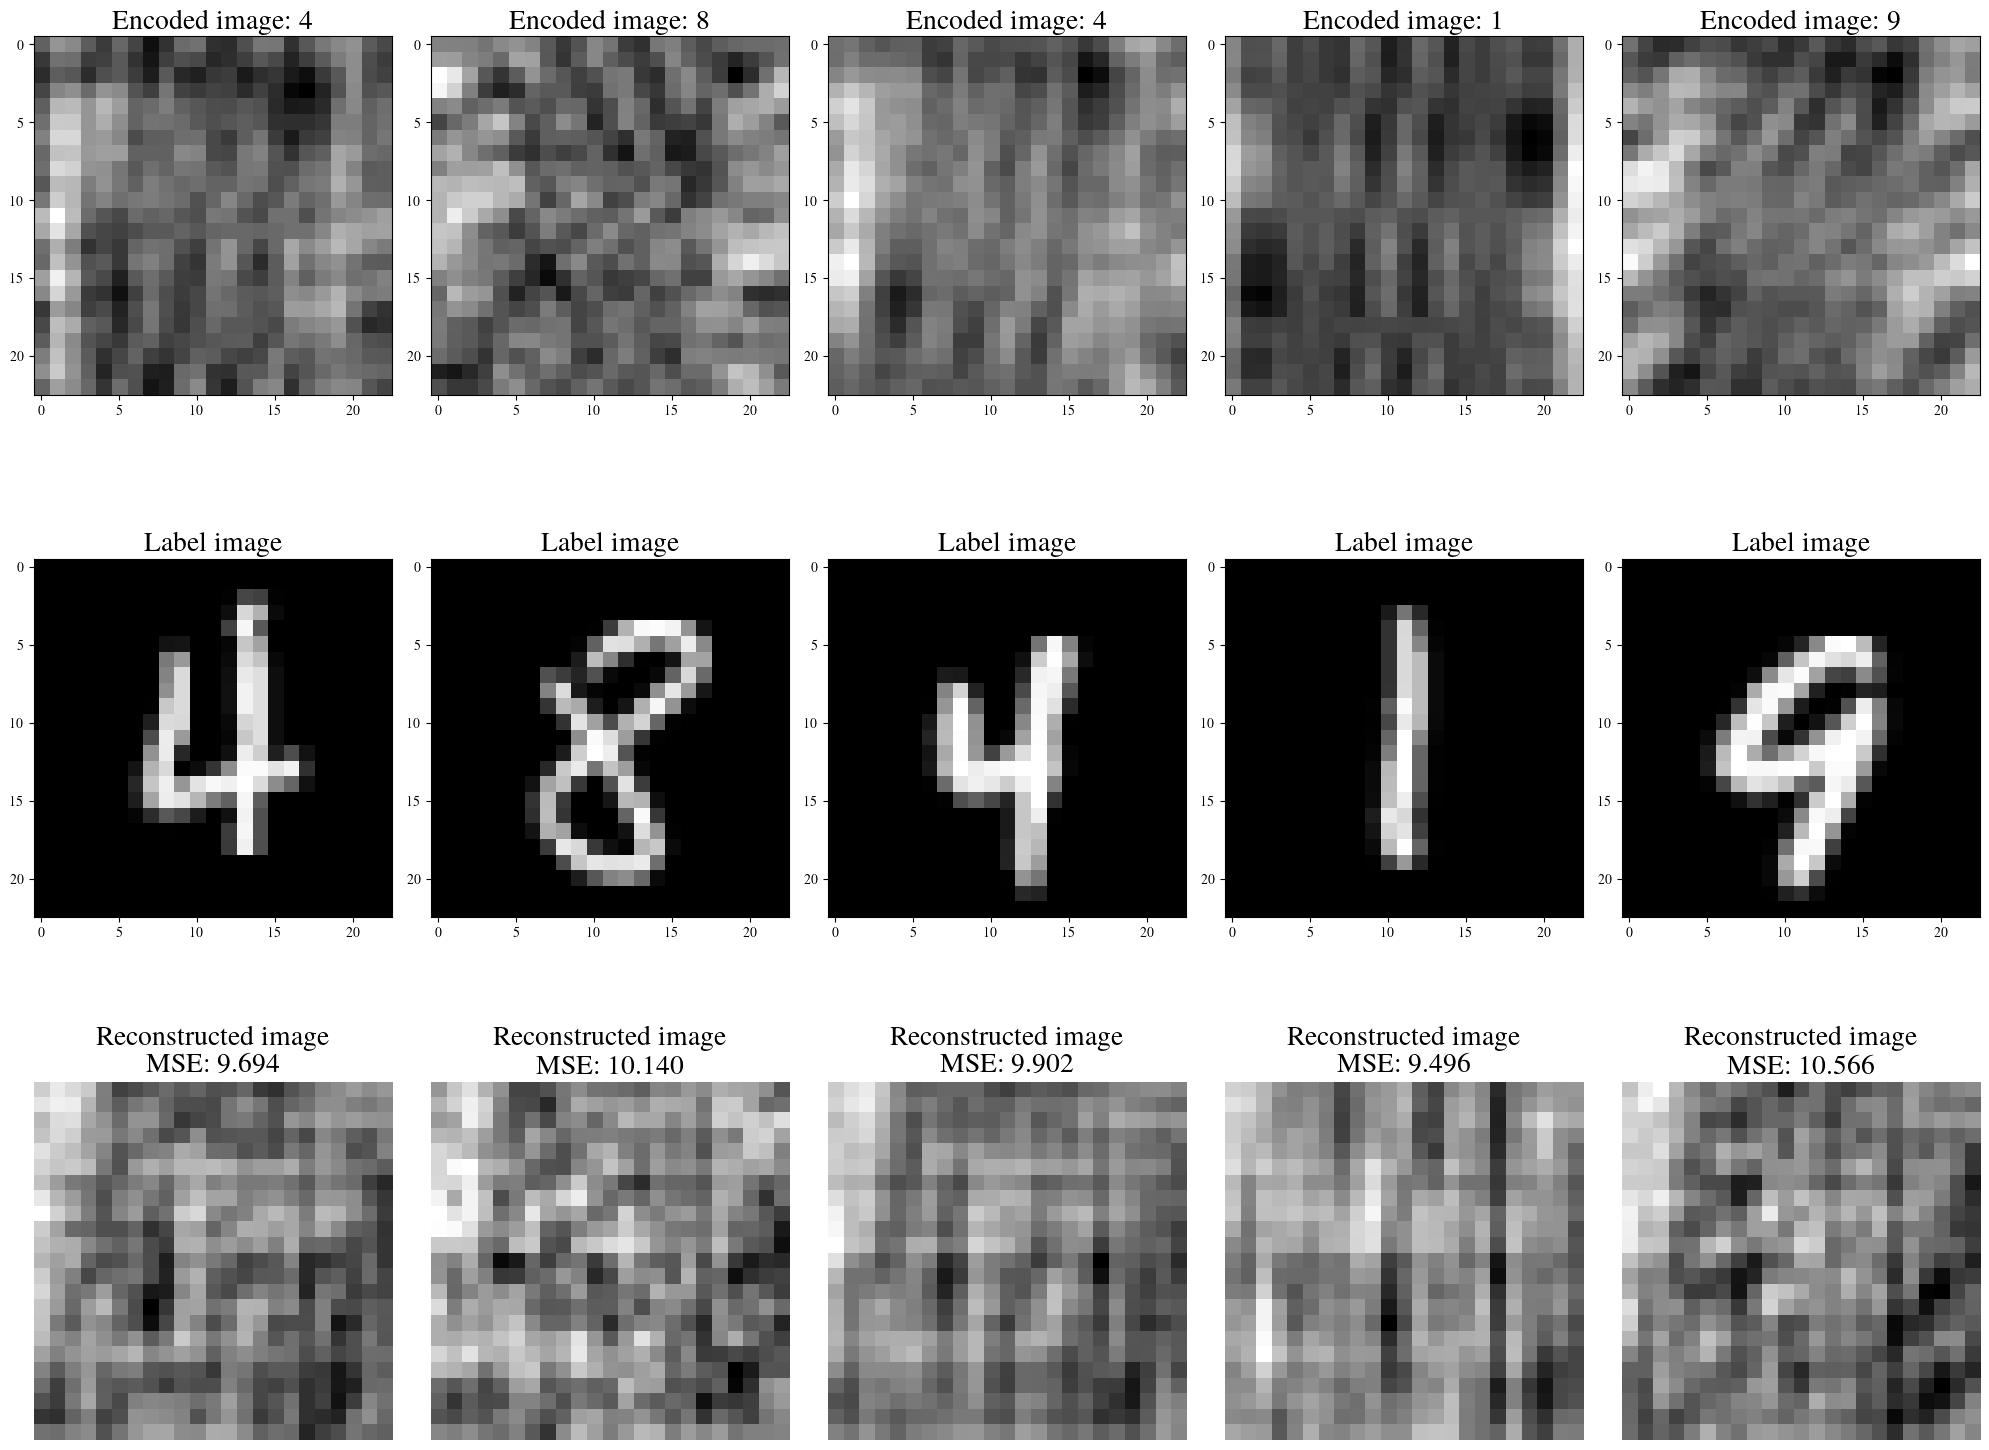

In [37]:
# Printing random images from the training dataset
#random_samples = np.random.randint(1, len(loaders['test']), (5))
seed = 10  
title_size = 20
label_size = 16

for plot_num,idx in enumerate(top_25per.sample(n=5, random_state=seed).index): # df[df.mse_score > 0.29].index
    # Plot encoded input image
    plt.subplot(3, 5, plot_num + 1)
    input_img = torch.reshape(test_outputs['img'][idx], (model.img_size,model.img_size))
    plt.imshow(input_img, cmap='gray')
    plt.title(f"Encoded image: {test_outputs['digit'][idx]}", fontsize=title_size)
    
    # Plot original label image
    plt.subplot(3, 5, plot_num + 6)
    label_image = torch.reshape(test_outputs['label'][idx], (model.img_size,model.img_size))
    plt.imshow(label_image, cmap='gray')
    plt.title('Label image', fontsize=title_size)
    
    # Plot reconstruction
    plt.subplot(3, 5, plot_num + 11)
    pred_image = torch.reshape(test_outputs['pred'][idx], (model.img_size,model.img_size))
    #pred_image = mura.normalize(pred_image.numpy())
    mse_recon = sklearn.metrics.mean_squared_error(label_image, pred_image)
    plt.imshow(pred_image, cmap='gray')
    plt.title(f'Reconstructed image \n MSE: {mse_recon: .3f}', fontsize=title_size)
    plt.axis('off')

plt.tight_layout()
#plt.suptitle("Worst 5 performing images", fontsize = title_size+4) #"Best 25\% Performing test images"
#plt.savefig(f'../figs/top25per_reconstructions_seed{seed}_{params["model"]}.png')
#plt.savefig(f'../figs/bottom25per_reconstructions_seed{seed}.png')
#plt.savefig(f'../figs/worst5_reconstructions.png')
plt.show()

# Try to make weights [-1,1]

In [10]:
# Instantiate model 
model = CNN(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 
# Load model if one is not loaded already
PATH = "../models/CNN/val_model_epoch_49_23kernel.pth"#path+f'models/CNN/{params["kind"]}_model_epoch_{params["epochs"]}.pth'
model.load_state_dict(torch.load(PATH))
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

Using the following parameters:
dataset: encoded_MNIST
learning_rate: 0.001
batch_size: 100
epochs: 50
kernel_size: 23
p: 23
image_size: 23
kind: recon
suffix: l_1_pen_lambda_
lambda: 10.0
model: recon_l_1_pen_lambda_1e+01
model_save_path: ../models/recon/recon_l_1_pen_lambda_1e+01.pth
A: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 

FileNotFoundError: [Errno 2] No such file or directory: '../models/CNN/val_model_epoch_49_23kernel.pth'

In [11]:
# Instantiate model 
no_activ_model = CNN(params)#.to(device)
no_activ_model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 
# Load model if one is not loaded already
PATH = "../models/CNN/CNN_no_activation_model_epoch_39.pth"#path+f'models/CNN/{params["kind"]}_model_epoch_{params["epochs"]}.pth'
no_activ_model.load_state_dict(torch.load(PATH))
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

Using the following parameters:
dataset: encoded_MNIST
learning_rate: 0.001
batch_size: 100
epochs: 50
kernel_size: 23
p: 23
image_size: 23
kind: recon
suffix: l_1_pen_lambda_
lambda: 10.0
model: recon_l_1_pen_lambda_1e+01
model_save_path: ../models/recon/recon_l_1_pen_lambda_1e+01.pth
A: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 

FileNotFoundError: [Errno 2] No such file or directory: '../models/CNN/CNN_no_activation_model_epoch_39.pth'

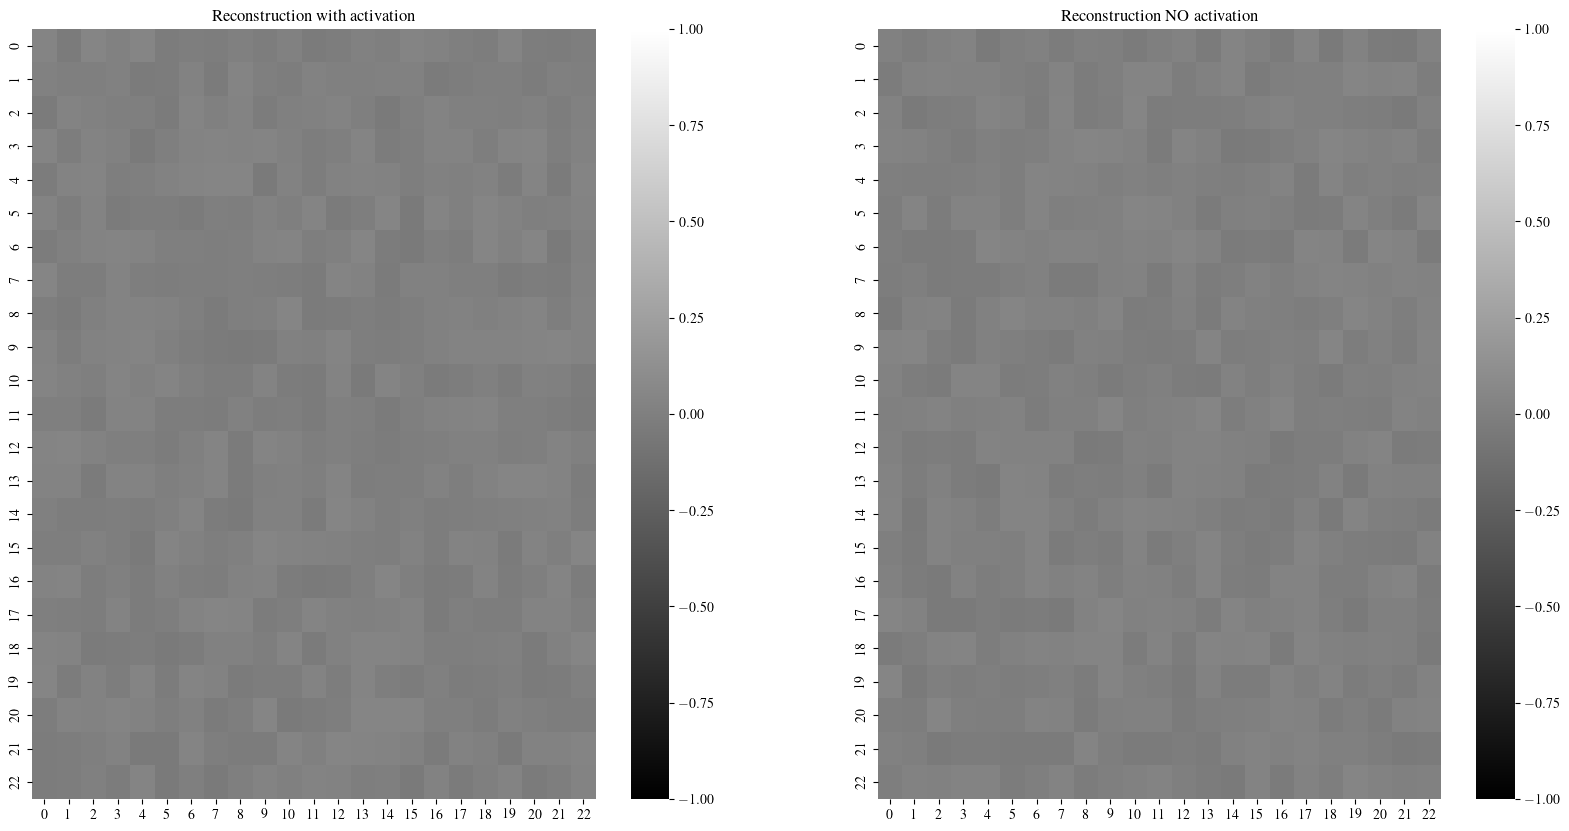

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(torch.squeeze(model.state_dict()["conv.weight"]), cmap='gray', ax=axs[0], vmin=-1, vmax=1)
sns.heatmap(torch.squeeze(no_activ_model.state_dict()["conv.weight"]), cmap='gray', ax=axs[1], vmin=-1, vmax=1)
axs[0].set_title("Reconstruction with activation")
axs[1].set_title("Reconstruction NO activation")
plt.show()

# To be deleted

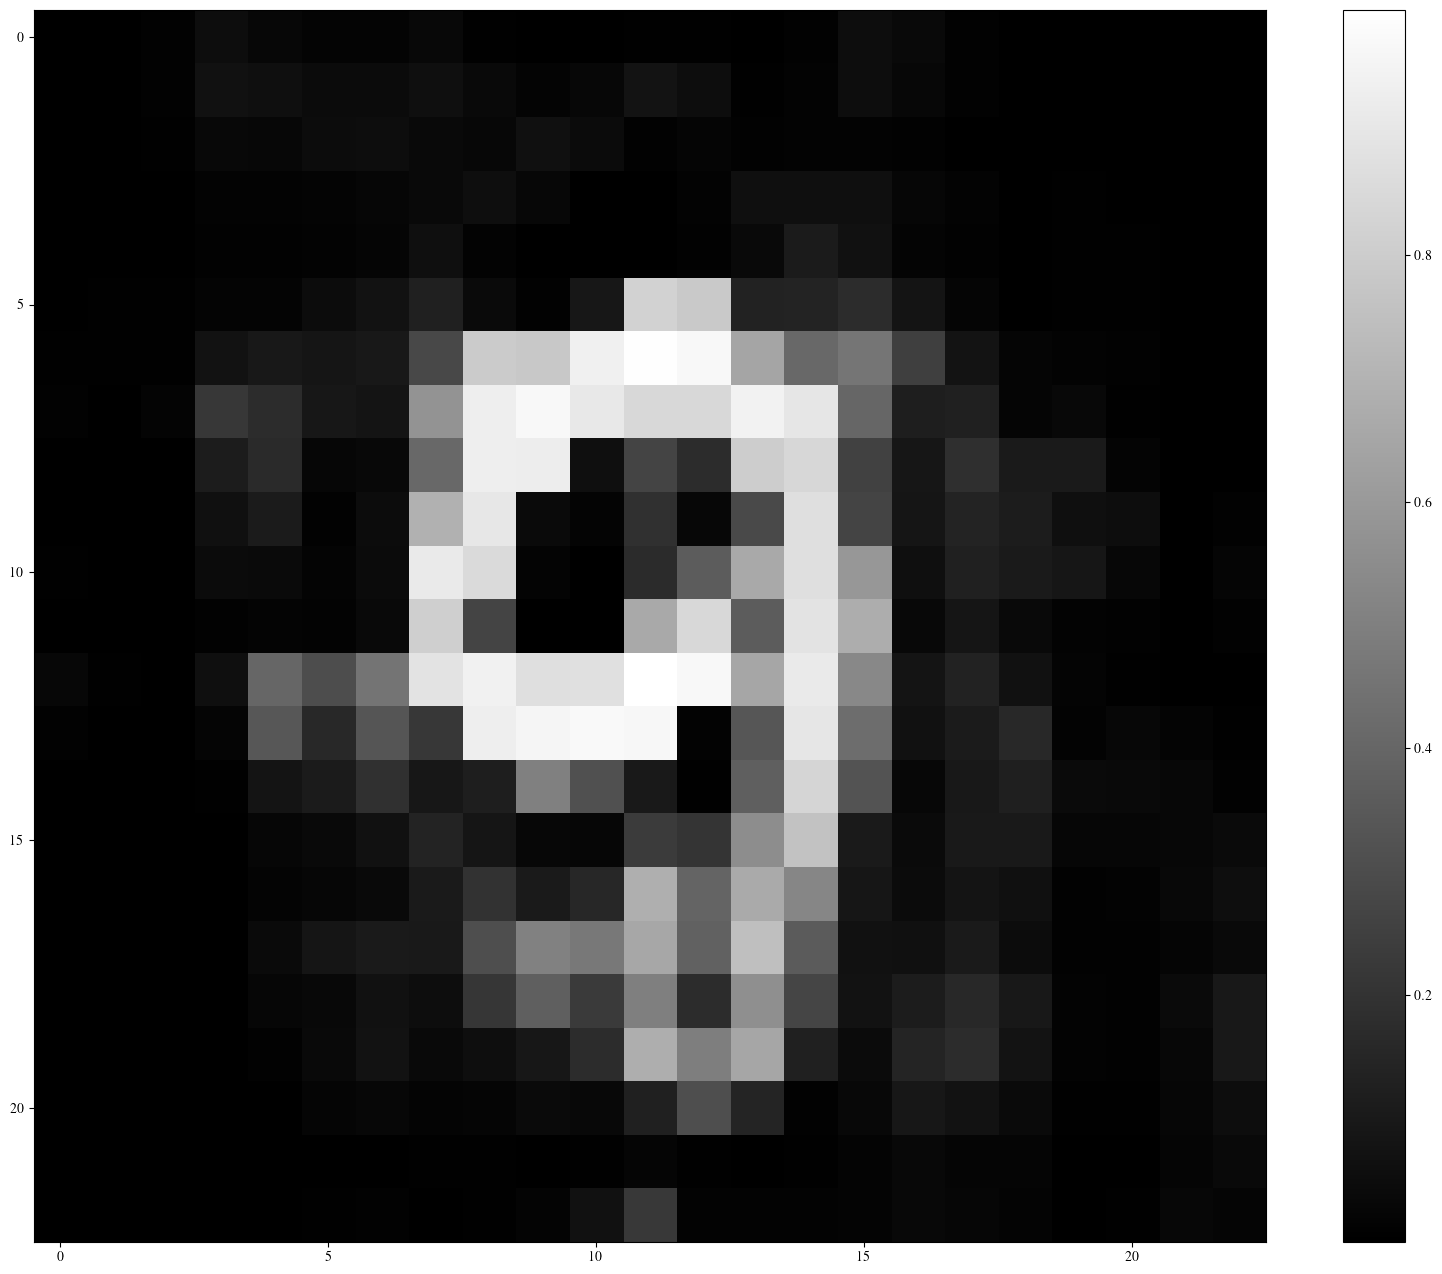

In [55]:
test = pred_image.numpy().copy()
test[np.where(test <=0)] = 0
plt.imshow(test, cmap='gray')
plt.colorbar()

In [81]:
cnn = CNN()
cnn.load_state_dict(torch.load('../models/mnist_50epochs.pth'))

<All keys matched successfully>

In [ ]:
torch.tensor((df.iloc[index].pred > 0.5).numpy().astype('float'))

In [82]:
df.pred.iloc[0].shape

torch.Size([1, 23, 23])

In [96]:
# Get one image from test set and reshape for model
#index = 1
cnn_pred = []
true_label = []

for index in top_25per.index: #range(len(df)):
    
    one_img = torch.reshape(df.pred.iloc[index],(1,1, model.img_size, model.img_size)) 

    # Input image batch into model to get predictions
    outputs = cnn(one_img)
    _, predicted = torch.max(outputs, 1)
    cnn_pred.append(predicted.numpy()[0])
    true_label.append(df.digit.iloc[index].numpy())
    #print(f"Model predicted {predicted.numpy()[0]}. True label is {df.digit.iloc[index].numpy()}")

In [31]:
from torchvision import models

In [32]:
resnet = models.resnet50(pretrained=True)

In [33]:
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0,0), bias=False)
resnet.fc = torch.nn.Linear(2048, 10, bias=True)

In [34]:
# Get one image from test set and reshape for model
#index = 1
cnn_pred = []
true_label = []

for index in top_25per.index: #range(len(df)):
    
    one_img = torch.reshape(df.pred.iloc[index],(1,1, model.img_size, model.img_size)) 

    # Input image batch into model to get predictions
    outputs = resnet(one_img)
    _, predicted = torch.max(outputs, 1)
    cnn_pred.append(predicted.numpy()[0])
    true_label.append(df.digit.iloc[index].numpy())
    #print(f"Model predicted {predicted.numpy()[0]}. True label is {df.digit.iloc[index].numpy()}")

[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

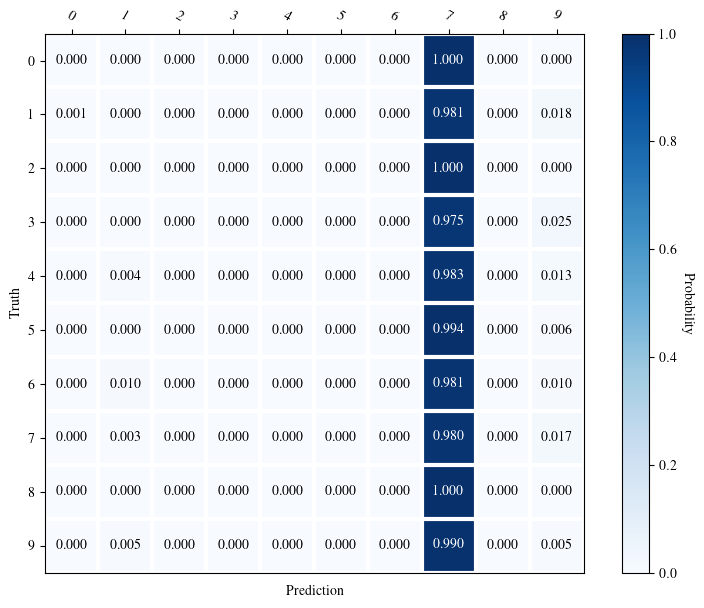

In [35]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in cnn_pred]
truths = [tru for tru in true_label]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")